# Approximate MPC Do-it-yourself
In this notebook we will design an approximate MPC controller all by ourselves. This will be a very simple first version, showing the basic steps required to generate an AMPC from an existing MPC. We divide this into four steps: Building the neural network, sampling data from the MPC and train this neural network on said dataset. Finally, we evaluate this AMPC in a closed loop simulation.
But first we will have to design an MPC controller for a given system, which we will do using the do-mpc toolbox.

In [83]:

import numpy as np
import matplotlib.pyplot as plt
import sys
from casadi import *
from do_mpc.tools import Timer
import jdc
# Add do_mpc to path. This is not necessary if it was installed via pip
import os
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

## Model
We consider the oscillating mass example as described in the figure. The model is defined as a discrete linear model with two states


In [84]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
x=model.set_variable('_x','x',(2,1))
u=model.set_variable('_u','u')
A=np.array([[0.5403, -0.8415],[0.8415, 0.5403]])
B=np.array([[-0.4597],[0.8415]])
model.set_rhs('x',A@x+B@u)
model.setup()

## MPC
The MPC controller uses the information from the system. All we have to do here is to set constraints, define the cost function and set parameters like the prediction horizon. At the end the setup() function is calles to finalize the MPC controller from which on its setting cannot be changed.

In [178]:
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 10,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.1,
}
Q=np.array([[2,0],[0,2]])
R=np.array([[1]])
mpc.set_param(**setup_mpc)
mpc.settings.supress_ipopt_output()
_x=model.x['x']
_u=model.u['u']
lterm=_x.T@Q@_x+_u.T@R@_u
mterm=_x.T@Q@_x
mpc.set_objective(mterm,lterm)

mpc.bounds['lower','_x','x']=np.array([[-5],[-5]])
mpc.bounds['upper','_x','x']=np.array([[5],[5]])
mpc.bounds['lower','_u','u']=np.array([[-1]])
mpc.bounds['upper','_u','u']=np.array([[1]])
mpc.setup()

C:\Users\smjsadam\Documents\Job\Forschung\Code\2025-workshop-dycops\do_mpc\controller\_mpc.py:885: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


## Estimator and Simulator
In order to run the MPC in closed-loop we need a simulator that behaves as the real system. It is possible to deviate from the model that is used in the MPC, for example to test plant-model mismatch. The estimator is needed if the model is designed, such that only certain states are measured. The do-mpc toolbox provides standard nonlinear estimators like the EKF and the MHE. In our case we will keep it simple and use full state feedback, as well as exactly the same model in the simulator as in the MPC.

In [179]:
estimator = do_mpc.estimator.StateFeedback(model)
simulator=do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)
simulator.setup()

## Closed-loop simulation
With this few steps we can already simulate our closed-loop MPC. We have t initialize the simulator, estimator and MPC with the same initial state. In every time step the MPC problem is solved, leading to an input that is applied to the simulator.

In [183]:
np.random.seed(99)

# Initial state
mpc.reset_history()
simulator.reset_history()
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
print(x0)
simulator.x0 = x0
estimator.x0 = x0
timer=Timer()
# Use initial state to set the initial guess.
mpc.set_initial_guess()
for k in range(10):
    timer.tic()
    u0 = mpc.make_step(x0)
    timer.toc()
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
timer.info()

[[ 1.03367135]
 [-0.0715296 ]]
Average runtime 7.0+-1.3416407864998738ms. Fastest run 5.0ms, slowest run 10.0ms.


## Visualization
There are many ways to visualize the closed loop simulation. The do-mpc toolbox provides a graphics class one can use for visualization either of the MPC or the simulator data. We show a method to plot the results after the loop, in the examples of do-mpc you will also see possibilities for real-time plotting of the states and even the predicted states.

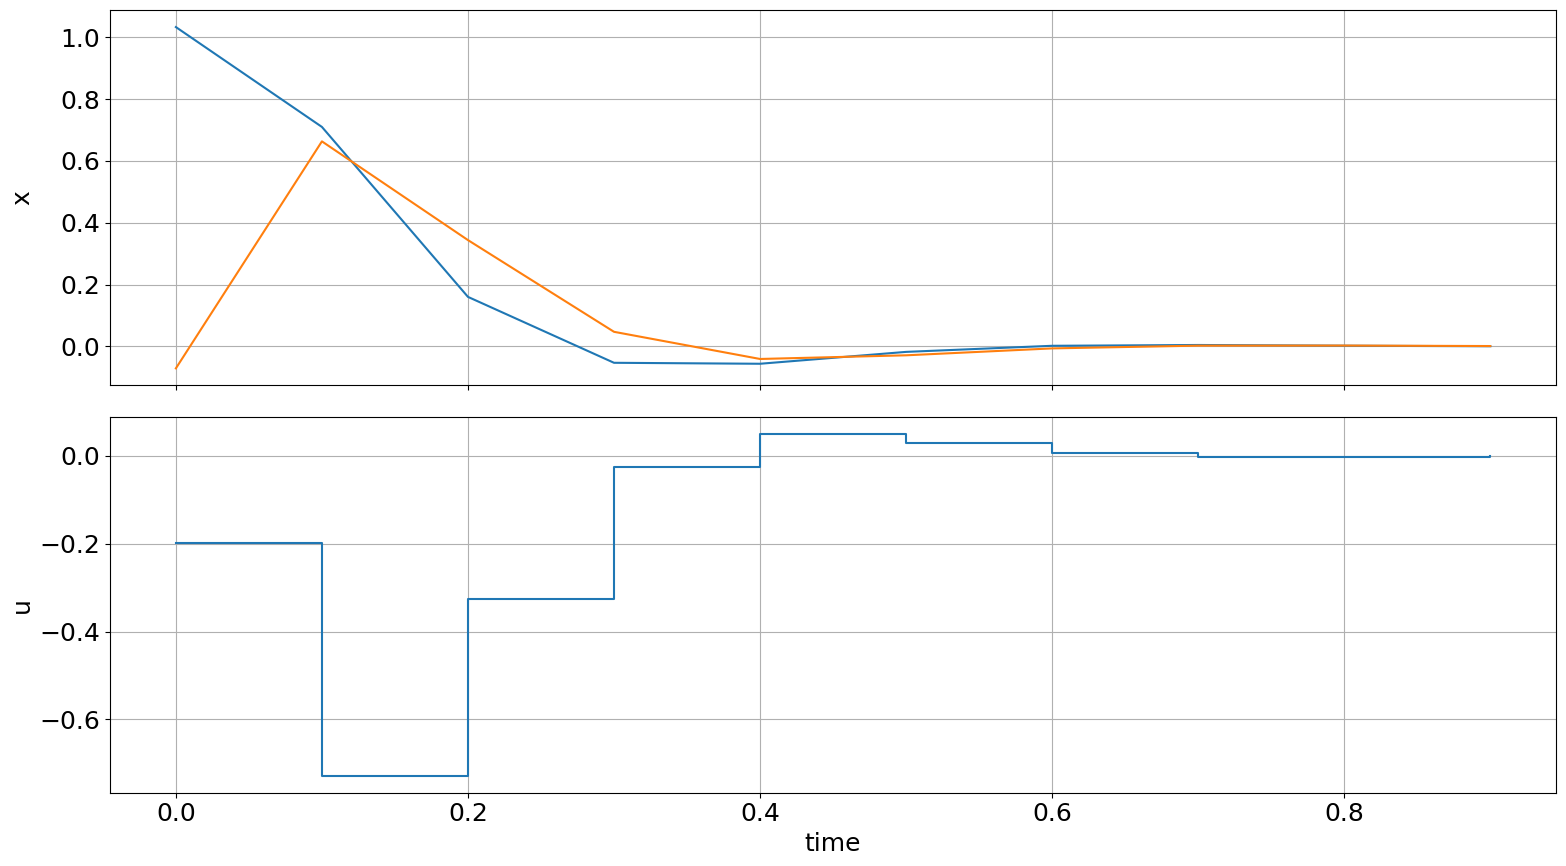

In [181]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()

# Approximate MPC
Now we want to create an AMPC that learns this behavior in a supervised fashion.

## Approximate MPC Definition
In its core AMPC is just a simple feedforward network with the current state X_k as input and the optimal first action u_0 as the output of the neural network. We will create this neural network with the Pytorch module. As you will see we can already use the definition f the AMPc to define some additional features that will im,prove the performance of the AMPC.

Let's start with the definition of a class feedforward neural network which inherits from the torch.nn.Module class of pytorch.

In [184]:
import torch
torch.set_default_dtype(torch.float64)
class FeedforwardNN(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hidden_layers, n_neurons, act_fn, output_act_fn):
        super().__init__()
        assert n_hidden_layers >= 0, "Number of hidden layers must be >= 0."
        self.n_in = n_in
        self.n_out = n_out
        self.n_layers = n_hidden_layers + 1
        self.n_neurons = n_neurons
        self.act_fn = act_fn
        self.output_act_fn = output_act_fn
        self.layers = torch.nn.ModuleList()
        for i in range(self.n_layers):
            if i == 0:
                self.layers.append(torch.nn.Linear(n_in, n_neurons))
                self.layers.append(self._get_activation_layer(act_fn))
            elif i == self.n_layers - 1:
                self.layers.append(torch.nn.Linear(n_neurons, n_out))
                if output_act_fn != "linear":
                    self.layers.append(self._get_activation_layer(output_act_fn))
            else:
                self.layers.append(torch.nn.Linear(n_neurons, n_neurons))
                self.layers.append(self._get_activation_layer(act_fn))
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
    def _get_activation_layer(self, act_fn):

        if act_fn == "relu":
            return torch.nn.ReLU()
        elif act_fn == "tanh":
            return torch.nn.Tanh()
        elif act_fn == "leaky_relu":
            return torch.nn.LeakyReLU()
        elif act_fn == "sigmoid":
            return torch.nn.Sigmoid()
        else:
            raise ValueError("Activation function not implemented.")

Next, we define our approximate MPC as a basic wrapper around this feedforward neural network. First, we initialize the network with the input and output sizes defined by the states and input sizes as well as the other parameters of the network. While in theory our AMPC is already set, with this network, there are some applications we need to consider to make it work in practise:
First, scaling of the input and output data for the training of the network will be fundamental. The scaling can be done using the state and input constraints of the MPC, that is why we call the function ```set_shift_values()```.
Secondly, it will be useful to store the past state and input in the AMPC as we will see in the closed loop application.



In [185]:
class ApproxMPC(torch.nn.Module):
    def __init__(self, mpc,n_hidden_layers=1, n_neurons=50, act_fn="relu", output_act_fn="linear"):
        # initiates torch.nn.Module
        super().__init__()
        # storage
        self.mpc = mpc

        if self.mpc.flags["set_rterm"]:
            self.net = FeedforwardNN(
                n_in=self.mpc.model.n_x + self.mpc.model.n_u,
                n_out=self.mpc.model.n_u,
                n_hidden_layers=n_hidden_layers,
                n_neurons=n_neurons,
                act_fn=act_fn,
                output_act_fn=output_act_fn,
            )
        else:
            self.net = FeedforwardNN(
                n_in=self.mpc.model.n_x,
                n_out=self.mpc.model.n_u,
                n_hidden_layers=n_hidden_layers,
                n_neurons=n_neurons,
                act_fn=act_fn,
                output_act_fn=output_act_fn)

        # storing initial guess
        self.x0 = self.mpc.x0
        self.u0 = self.mpc.u0
        # Prepare the scaling
        self.lbx = torch.tensor(DM(self.mpc._x_lb).full().T, dtype=torch.float64)
        self.ubx = torch.tensor(DM(self.mpc._x_ub).full().T, dtype=torch.float64)
        self.lbu = torch.tensor(DM(self.mpc._u_lb).full().T,  dtype=torch.float64)
        self.ubu = torch.tensor(DM(self.mpc._u_ub).full().T,  dtype=torch.float64)
        self.set_shift_values()


The scaling can be done by operating within the bounds of the state and input constraints, as any feasible data point will be in there. All we need is to extract these bounds from the MPC and define a shift and range with which we can scale our data. (first task)

In [186]:
    %%add_to ApproxMPC
    def set_shift_values(self):


        if self.mpc.flags["set_rterm"]:
            lb = torch.concatenate((self.lbx, self.lbu), axis=1)
            ub = torch.concatenate((self.ubx, self.ubu), axis=1)
        else:
            lb = self.lbx
            ub = self.ubx
        self.x_shift = torch.tensor(lb)
        self.x_range = torch.tensor(ub - lb)
        self.y_shift = torch.tensor(self.lbu)
        self.y_range = torch.tensor(self.ubu - self.lbu)

        return None

    def scale_inputs(self, x):

        x_scaled = (x - self.x_shift) / self.x_range

        return x_scaled
    def rescale_outputs(self, y_scaled):
        y = y_scaled * self.y_range + self.y_shift
        return y

Now that we have prepared the scaling we need an evaluation function, one that we use in the training on the scaled dataset and one we can use in the closed-loop evaluation.
The first one is easy as it is simply

In [187]:
%%add_to ApproxMPC
def forward(self, x):
    y = self.net(x)
    return y


In the latter we don't want to care anymore about scaling it will all happen in one function, which is the analogy to the ```make_step()```-function of the original MPC, where now only a neural network is evaluated. Before we get tothat here is another trick that can improve the quality of the results: As we know the input constraints, we can clip the output of the neural network to be within these bounds. This is done in the function ```clip_control_actions()```. This is not strictly necessary, but it can help to avoid large deviations from the optimal solution. The function is called in the ```make_step()```-function.

In [188]:
%%add_to ApproxMPC
def clip_control_actions(self, y):

    if self.lbu is not None:
        y = torch.max(y, self.lbu)
    if self.ubu is not None:
        y = torch.min(y, self.ubu)
    if self.lbu is None and self.ubu is None:
        raise ValueError("No output constraints defined. Clipping not possible.")
    return y

Now let's bring this all together in our ```make_step()```-function. This function is called in the closed-loop simulation and is the equivalent to the ```make_step()```-function of the original MPC. It takes the current state and the previous control input as input and returns the next control input. The function first checks if a previous control input is given, if not it uses the last one. Then it scales the input and evaluates the neural network. Finally, it rescales the output and clips it to the bounds of the control input.

In [189]:
%%add_to ApproxMPC
@torch.no_grad()
def make_step(self, x0, u_prev=None, clip_to_bounds=True):

    if u_prev is not None:
        self.u0 = u_prev

    if self.mpc.flags["set_rterm"]:
        x = np.concatenate((x0, DM(self.u0).full()), axis=0).squeeze()
    else:
        x = x0

    if self.mpc.flags["set_rterm"]:
        x = torch.tensor(x).reshape(
            (-1, self.mpc.model.n_x + self.mpc.model.n_u)
        )
    else:
        x = torch.tensor(x).reshape(
            (-1, self.mpc.model.n_x)
        )

    x_scaled = self.scale_inputs(x)
    y_scaled = self.net(x_scaled)
    y = self.rescale_outputs(y_scaled)


    if clip_to_bounds:
        y = self.clip_control_actions(y)


    y = y.detach().cpu().numpy().reshape((-1, 1))


    # storing
    self.u0 = y
    return y

We have now completed the AMPC definition. Finally, we can also store our network parameters or load network parameters into an existing AMPC.

In [190]:
%%add_to ApproxMPC
def save_to_state_dict(self, directory="model.pth"):

    torch.save(self.net.state_dict(), directory)

def load_from_state_dict(self, directory="model.pth"):

    self.net.load_state_dict(torch.load(directory))

That's it for the AMPC. What we still need is to generate some data using the MPC (Sampling) and train the AMPC on this dataset. For this let us now create an instance of the approximate MPC class

In [191]:
approx_mpc = ApproxMPC(mpc)

<string>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Sampling
The next step is to generate data for the training of the AMPC. Again, on first sight it is easy, as we just have to run the MPC in a loop until we have sufficient number of data points. We will show, that optimal state-space coverage can improve the quality of the AMPC, which is why we will focus here on two sampling methods, the open-loop sampling and the closed loop sampling.


Both approaches require a number of starting states and in our case previous inputs, which in general are randomly chosen within the state and input space. We will first start with the open-loop sampling in which we sample one data point for each of these starting values. In this case it makes sense to sample uniformly within the state and input space:

In [192]:
n_samples=1000
x_samp = np.random.uniform(
    low=approx_mpc.lbx, high=approx_mpc.ubx, size=(n_samples, mpc.model.n_x)
)


Now, we sample by initializing our MPC with each of these states and previous inputs and run it for one step. If the solution is feasible, we can add this state/optimal input pair to our dataset. For simplicity we will use a very simple dictionary to store the data

In [193]:

data_open_loop = {
    "x": [],
    "u": []
}
for k in range(n_samples):
    mpc.reset_history()
    # set initial state
    mpc.x0 = x_samp[k]

    # set initial guess
    mpc.set_initial_guess()
    # solve MPC
    u0 = mpc.make_step(mpc.x0)
    # check if solution is feasible
    if mpc.solver_stats["success"]:
        data_open_loop["x"].append(x_samp[k])
        data_open_loop["u"].append(u0.reshape(-1))

So far, we have not taken any knowledge about the model into account. It is clear that uniformly sampling within the state space might not yield the best performance in a closed-loop application. Some states will be visited more frequently than others, while the AMPC is trained on the uniformly sampled data. Especially in our case, a better approach would be a closed-loop sampling where we run the MPC from reasonable starting states within a much smaller state region that reflects possible initial values. We will then run the MPC in closed-loop for a certain number of steps which will result in a trajectory of states and inputs, that mimic the real applictaion of the AMPC in a much better way.

In [194]:

n_samples = 200
traj_length = 5

x_samp = np.random.uniform(
    low=approx_mpc.lbx, high=approx_mpc.ubx, size=(n_samples, mpc.model.n_x)
)

data_closed_loop = {
    "x": [],
    "u": []
}
for k in range(n_samples):
    mpc.reset_history()
    # set initial state
    mpc.x0 = x_samp[k]
    print(k)
    for m in range(traj_length):

        # set initial guess
        mpc.set_initial_guess()
        # solve MPC
        u0 = mpc.make_step(mpc.x0)
        x0 = simulator.make_step(u0)
        # check if solution is feasible
        if mpc.solver_stats["success"]:
            data_closed_loop["x"].append(x_samp[k])
            data_closed_loop["u"].append(u0.reshape((-1)))
        else:
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


We have now two datasets on which we can train our AMPC.

## Training
We will do the Training in Pytorch. First we import the necessary features from Pytorch for our training

In [195]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset

Before training the AMPC we need to convert the dataset into Pytorch tensors. During the process we can also scale the dataset. Let's define a function ````scale_dataset()```
to process both datasets (next task?)

In [196]:
def scale_dataset(data, approx_mpc):
    x = data["x"]
    u = data["u"]
    x_tensor = torch.tensor(x, dtype=torch.float64)
    u_tensor = torch.tensor(u, dtype=torch.float64)
    x_scaled = (x_tensor - approx_mpc.x_shift) / approx_mpc.x_range
    u_scaled = (u_tensor - approx_mpc.y_shift) / approx_mpc.y_range
    scaled_data = TensorDataset(x_scaled, u_scaled)
    return scaled_data

We can now scale our two datasets

In [197]:

closed_loop_scaled = scale_dataset(data_closed_loop,approx_mpc)
#print(len(data_closed_loop["x"]))
open_loop_scaled = scale_dataset(data_open_loop,approx_mpc)

For training the neural network we can make use iof the standard features from Pytorch. We can use ```random_split()``` to generate a training and validation dataset. Using a DataLoader will be helpful for batch training. Finally we use the Adam Optimizer. We establish a function ```load_data()``` that takes the dataset, the AMPC and the batch size as input and returns the dataloader and the optimizer. The function also takes care of splitting the dataset into a training and validation set.

In [198]:
def load_data(data, approx_mpc, batch_size=1000, shuffle=True, val=0.25, learning_rate=1e-3):


    training_data, val_data = random_split(
        data, [1 - val, val], generator=torch.Generator()
    )
    train_dataloader = DataLoader(
        training_data,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=torch.Generator(),
    )
    test_dataloader = DataLoader(
        val_data, batch_size=batch_size, shuffle=shuffle, generator=torch.Generator()
    )
    optimizer = optim.Adam(approx_mpc.net.parameters(), lr=learning_rate)
    return train_dataloader, test_dataloader, optimizer

As we have two datasets let's also generate two approximate MPC instances we can train.

In [199]:
approx_mpc_closed_loop = ApproxMPC(mpc)
approx_mpc_open_loop = ApproxMPC(mpc)

train_dataloader_open, test_dataloader_open, optimizer_open=load_data(open_loop_scaled, approx_mpc_open_loop)
train_dataloader_closed, test_dataloader_closed, optimizer_closed=load_data(closed_loop_scaled, approx_mpc_closed_loop)

<string>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
<string>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


With this step, we have the data ready for the training loop. In its easiest form training the network is just evaluating the loss over batches of the training data for a number of epochs, while the weights are updated using the gradients from the loss function. First we define our training functions we will call during the epochs

In [200]:
def train_step(optim, x, y,approx_mpc):

    optim.zero_grad()
    y_pred = approx_mpc(x)
    loss = torch.nn.functional.mse_loss(y_pred, y)
    loss.backward()
    optim.step()
    return loss.item()

def train_epoch(optim, train_loader,approx_mpc):

    train_loss = 0.0
    # Training Steps
    for idx_train_batch, batch in enumerate(train_loader):
        x, y = batch
        loss = train_step(optim, x, y,approx_mpc)
        train_loss += loss
    n_train_steps = idx_train_batch + 1
    train_loss = train_loss / n_train_steps
    return train_loss

During training we also want to keep track of our validation error using these two functions

In [201]:
def validation_step(x, y,approx_mpc):

        with torch.no_grad():
            y_pred =approx_mpc(x)
            loss = torch.nn.functional.mse_loss(y_pred, y)
        return loss.item()

def validation_epoch(val_loader,approx_mpc):

    val_loss = 0.0
    for idx_val_batch, batch in enumerate(val_loader):
        x_val, y_val = batch
        loss = validation_step(x_val, y_val,approx_mpc)
        val_loss += loss
    n_val_steps = idx_val_batch + 1
    val_loss = val_loss / n_val_steps
    return val_loss


Finally, we also want to log the process and visualize the training and validation error over the epochs. In general, you would also store the history which we omit here (next task)

In [202]:
def log_value(history, val, key):

    if torch.is_tensor(val):
        val = val.detach().cpu().item()
    assert isinstance(val, (int, float)), "Value must be a scalar."
    if not key in history.keys():
        history[key] = []
    history[key].append(val)

def print_last_entry(history, keys=["epoch,train_loss"]):
    """This method prints the last entry of the history.
    The keys to be printed can be provided as a list. Possible entries can be 'epoch', 'train_loss', 'val_loss', 'lr'.

    Args:
        keys (list, optional): Store the keys. Possible entries are 'epoch', 'train_loss', 'val_loss', 'lr'.. Defaults to ["epoch,train_loss"].
    """
    assert isinstance(keys, list), "Keys must be a list."
    for key in keys:
        # check wether keys are in history
        assert key in history.keys(), "Key not in history."
        print(key, ": ", history[key][-1])

def visualize_history(history):

    # setting up plot

    fig, ax = plt.subplots(2, figsize=(8, 3 * 2))
    fig.suptitle("Training History")

    # plotting learning rate
    ax[0].plot(history["epoch"], history["lr"], label="Learning Rate")
    ax[0].set_yscale("log")
    ax[0].set_ylabel("Learning Rate")

    # plotting losses
    ax[1].plot(
        history["epoch"], history["train_loss"], label="Training Loss"
    )
    ax[1].plot(
        history["epoch"],history["val_loss"], label="Validation Loss"
    )
    ax[1].set_ylabel("Losses")
    ax[1].set_yscale("log")
    ax[1].legend()

    # adding x axis label
    ax[-1].set_xlabel("epoch")


    plt.show()

    return None

Now we are all set for the main training loop, which we define as a new function

In [203]:
def training(train_dataloader,test_dataloader, optimizer,approx_mpc,n_epochs=2000):
        #lr_scheduler= optim.lr_scheduler.ReduceLROnPlateau(
        #    optimizer, mode="min", factor=0.5, patience=10, verbose=True
        #)
        history = {"epoch": []}
        for epoch in range(n_epochs):
            # Training
            train_loss = train_epoch(optimizer, train_dataloader,approx_mpc)

            # Logging
            log_value(history,epoch, "epoch")
            log_value(history,train_loss, "train_loss")
            log_value(history,optimizer.param_groups[0]["lr"], "lr")
            print_keys = ["epoch", "train_loss"]

            # Validation
            if test_dataloader is not None:
                val_loss = validation_epoch(test_dataloader,approx_mpc)
                log_value(history, val_loss, "val_loss")
                print_keys.append("val_loss")

            # Print
            if (epoch + 1) % 10 == 0:
                print_last_entry(history,keys=print_keys)
                print("-------------------------------")
            # scheduler

            #lr_scheduler.step(val_loss)

            # break if training min learning rate is reached
            #if optimizer.param_groups[0]["lr"] < 1e-7:
            #    break

        visualize_history(history)

        # end
        return None

We can now run this main loop for both datasets. First let's check the open-loop dataset

epoch :  9
train_loss :  0.7053351599876829
val_loss :  0.6860514648038698
-------------------------------
epoch :  19
train_loss :  0.5920923115090617
val_loss :  0.5755910776035519
-------------------------------
epoch :  29
train_loss :  0.5010650153058523
val_loss :  0.48738310341549435
-------------------------------
epoch :  39
train_loss :  0.42970184825333346
val_loss :  0.418616681399469
-------------------------------
epoch :  49
train_loss :  0.3748295138325713
val_loss :  0.3659925667690634
-------------------------------
epoch :  59
train_loss :  0.33318250242437325
val_loss :  0.3261953198915986
-------------------------------
epoch :  69
train_loss :  0.3017343423422263
val_loss :  0.2961281043707023
-------------------------------
epoch :  79
train_loss :  0.2779840472955889
val_loss :  0.2733285202976865
-------------------------------
epoch :  89
train_loss :  0.2597639153452106
val_loss :  0.2555590397658245
-------------------------------
epoch :  99
train_loss :  0

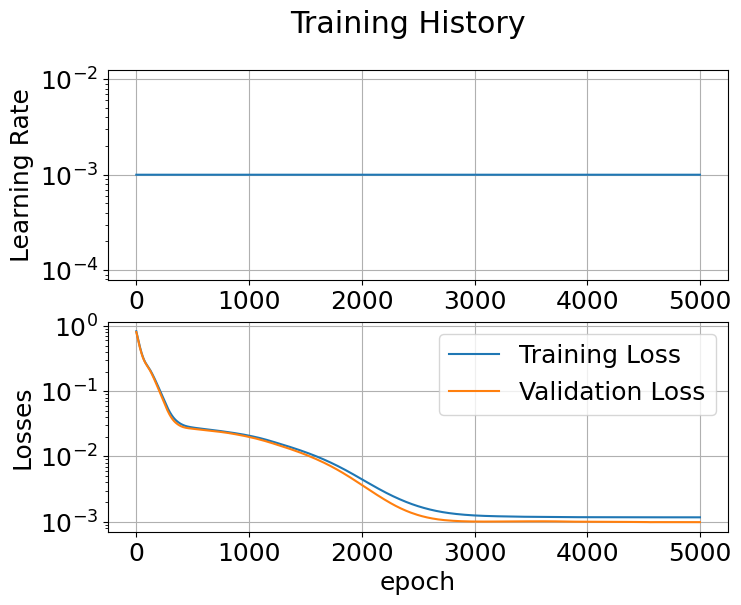

In [204]:
training(train_dataloader_open,test_dataloader_open, optimizer_open,approx_mpc_open_loop,n_epochs=5000)

And now let us compare it against the closed-loop dataset

epoch :  9
train_loss :  0.3807864406258575
val_loss :  0.3776641308459643
-------------------------------
epoch :  19
train_loss :  0.29615737378937895
val_loss :  0.29359365714541225
-------------------------------
epoch :  29
train_loss :  0.24288509944022613
val_loss :  0.24060684617739744
-------------------------------
epoch :  39
train_loss :  0.21152084407847765
val_loss :  0.20908803139057522
-------------------------------
epoch :  49
train_loss :  0.19241862877962104
val_loss :  0.18951609738370054
-------------------------------
epoch :  59
train_loss :  0.1786190038952003
val_loss :  0.1751468997854266
-------------------------------
epoch :  69
train_loss :  0.1663737178698233
val_loss :  0.16249930518879385
-------------------------------
epoch :  79
train_loss :  0.15453558645988885
val_loss :  0.15040007772743247
-------------------------------
epoch :  89
train_loss :  0.14286036878180464
val_loss :  0.13861486523172434
-------------------------------
epoch :  99
trai

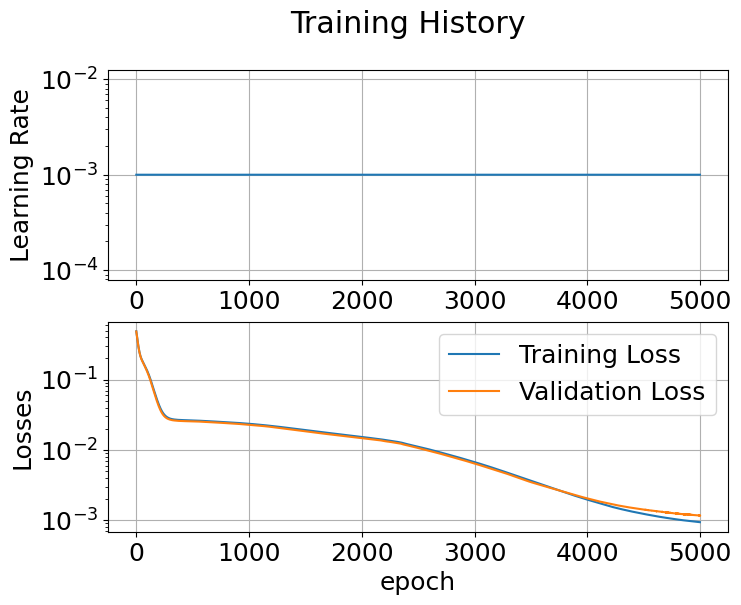

In [205]:
training(train_dataloader_closed,test_dataloader_closed, optimizer_closed,approx_mpc_closed_loop,n_epochs=5000)

## Evaluation
We have trained our AMPC on two datasets. In the final step we can simply evaluate it simultaneously in a closed-loop simulation as it was done on the MPC. We will again track the mean computation time as well as stage cost to evaluate the performance from of both AMPC again the MPC.

[[ 1.03367135]
 [-0.0715296 ]]


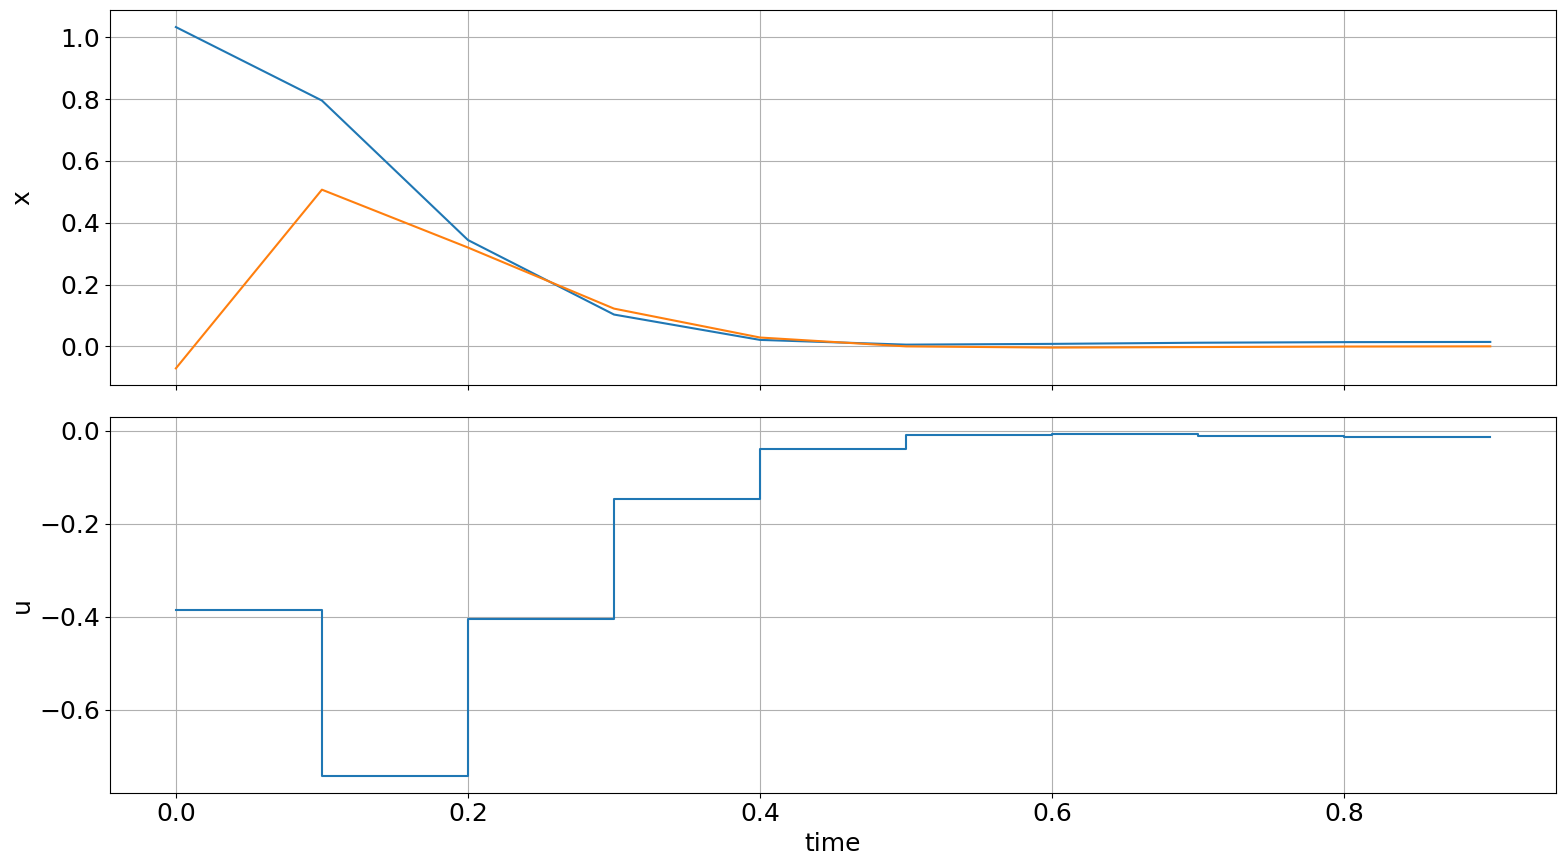

In [206]:
np.random.seed(99)

# Initial state
mpc.reset_history()
simulator.reset_history()
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
print(x0)
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()
for k in range(10):
    u0 = approx_mpc_open_loop.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
fig, ax, graphics = do_mpc.graphics.default_plot(simulator.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()

[[ 1.03367135]
 [-0.0715296 ]]


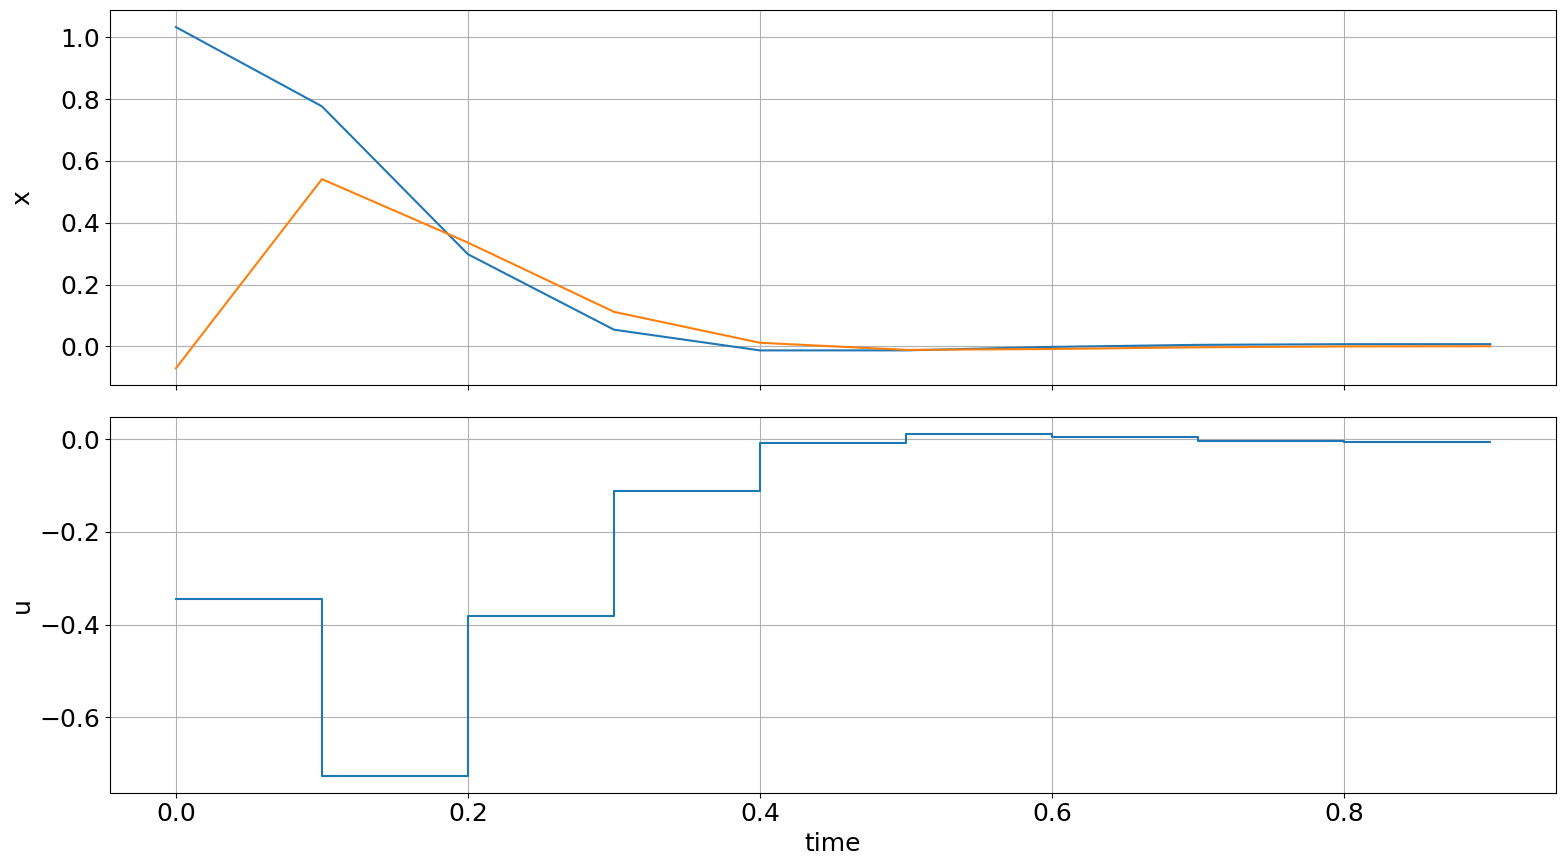

In [207]:
np.random.seed(99)

# Initial state
mpc.reset_history()
simulator.reset_history()
e = np.ones([model.n_x,1])
x0 = np.random.uniform(-3*e,3*e) # Values between +3 and +3 for all states
mpc.x0 = x0
print(x0)
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()
for k in range(10):
    u0 = approx_mpc_closed_loop.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
fig, ax, graphics = do_mpc.graphics.default_plot(simulator.data, figsize=(16,9))
graphics.plot_results()
graphics.reset_axes()